<a href="https://colab.research.google.com/github/antoinexp/Statistical-Physics/blob/main/ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd
from IPython.display import display
from IPython.display import clear_output
import tensorflow as tf
import tensorflow_probability as tfp
import itertools
import seaborn as sns
import scipy.stats as st
from scipy.optimize import fsolve, root_scalar
from scipy.special import expit
from itertools import product
import matplotlib as mpl


# Exercise 1.4

In [ ]:
class MCMCModel(object):
  def __init__(self, beta, h, N):
    self.beta = beta
    self.h = h
    self.N = N
    self._initSpins()
  
  def _initSpins(self):
    self.spins = np.ones(self.N)
    self.E = self._energy()
    self.history = [dict(E=self.E, m=self.spins.mean())]

  def _energy(self):
    m = self.spins.mean()
    return -self.N*m*(0.5*m + self.h)

  def update(self):
    i = np.random.randint(self.N)
    self.spins[i] *= -1

    newE = self._energy()
    deltaE = self.E - newE
    r = np.random.rand()
    if r < np.exp(self.beta*deltaE):
      self.E = newE
      self.history.append(dict(E=self.E, m=self.spins.mean()))
    else:
      self.history.append(self.history[-1])
      self.spins[i] *= -1
    return self
    
  def multipleUpdates(self, n):
    for _ in range(n):
      self.update()
    return self

In [ ]:
def run(n,config):
  """ This function is used to sample multiple runs of MCMC algorithm and pick 
  the end results n times
  """
  res = []
  for _ in range(n):
    model = MCMCModel(**config)
    model.multipleUpdates(1000*model.N)
    res.append(model.history[-1])
  return pd.DataFrame(res)

---
## Question 1
for $beta = 1.2, h=0.0$

Theoretical solution : $m^\star = \pm 0.65857$

In [ ]:
def mEvolution(N):
  config = dict(beta=1.2, h=0., N=N)
  model = MCMCModel(**config).multipleUpdates(100*config["N"])
  df = pd.DataFrame(model.history)
  df.index = np.arange(len(df))/config["N"]
  df["m"].plot(grid=True, xlabel="time (rescaled)", ylabel="m")
  plt.axhline(y=0.65857, linestyle="--", color="r")
  plt.axhline(y=-0.65857, linestyle="--", color="r")
  plt.ylim(-1.2,1.2)

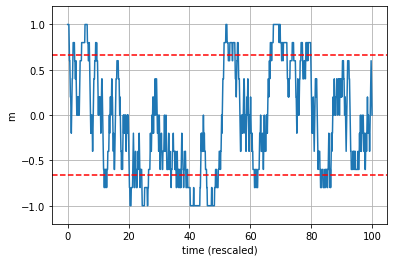

In [ ]:
mEvolution(10)

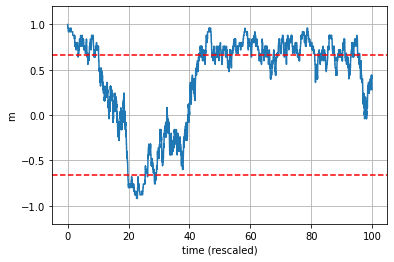

In [ ]:
mEvolution(50)

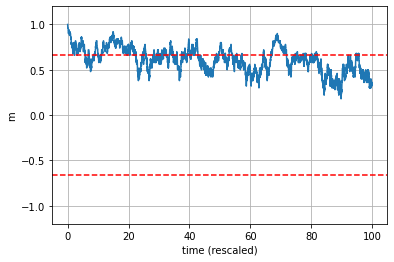

In [ ]:
mEvolution(100)

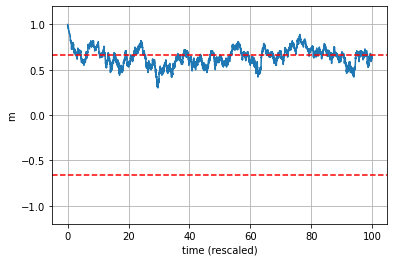

In [ ]:
mEvolution(200)

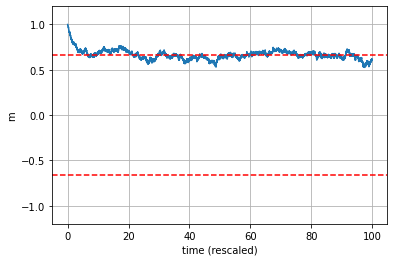

In [ ]:
mEvolution(1000)

We see clearly that as N grows, the path seems to converge towards one of the expected mean-field solution. 
That being said, we only see one solution over one instance. So we could go slightly further in time and sample 30 paths and look at the distribution of the end value.

We clearly see the two spikes around $\pm m^\star$ even for "relatively small" $N=100$



In [ ]:
config = dict(beta=1.2, h=0., N=100)
df = run(100,config)

(-1.0, 1.0)

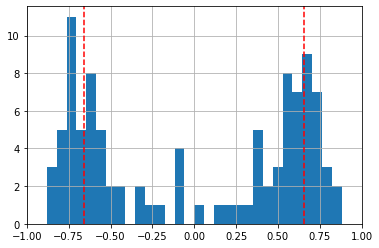

In [ ]:
df["m"].hist(bins=30)
plt.axvline(x=-0.65857, linestyle="--", color="r")
plt.axvline(x=0.65857, linestyle="--", color="r")
plt.xlim(-1,1)

---
## Question 2
for $beta = 1.2, h=-0.1$

Theoretical solution : $m^\star = -0.787629$


In [ ]:
def mEvolution(N):
  config = dict(beta=1.2, h=-0.1, N=N)
  model = MCMCModel(**config).multipleUpdates(100*config["N"])
  df = pd.DataFrame(model.history)
  df.index = np.arange(len(df))/config["N"]
  df["m"].plot(grid=True, xlabel="time (rescaled)", ylabel="m")
  plt.axhline(y=-0.787629, linestyle="--", color="r")
  plt.ylim(-1.2,1.2)

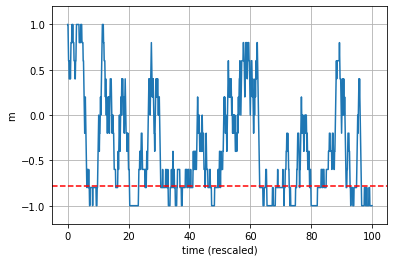

In [ ]:
mEvolution(10)

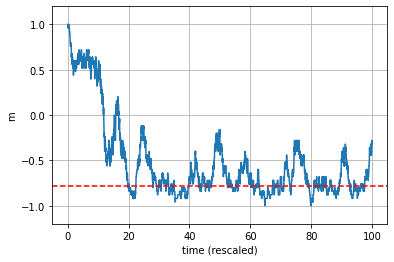

In [ ]:
mEvolution(50)

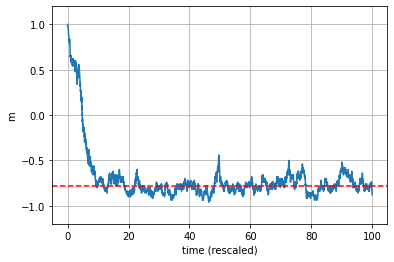

In [ ]:
mEvolution(100)

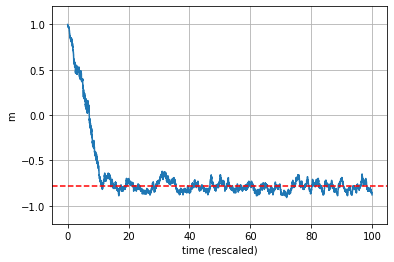

In [ ]:
mEvolution(200)

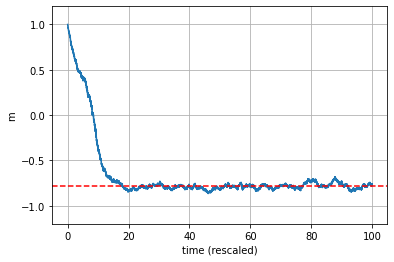

In [ ]:
mEvolution(1000)

Same remarks as before, as N grows, it seems to converge towards the expected (unique) value of the mean field solution.

We go again slightly further in time and sample 30 paths and look at the distribution of the end value.
We clearly see the spike in $m^\star$.


In [ ]:
config = dict(beta=1.2, h=-0.1, N=100)
df = run(100,config)

(-1.0, 1.0)

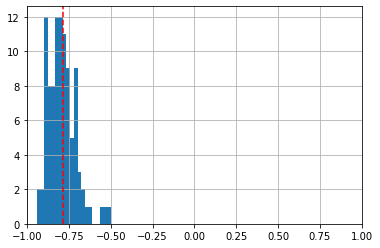

In [ ]:
df["m"].hist(bins=20)
plt.axvline(x=-0.787629, linestyle="--", color="r")
plt.xlim(-1,1)

# Exercise 1.5

In [ ]:
class GlauberModel(object):
  def __init__(self, beta, h, N, spins=None):
    self.beta = beta
    self.h = h
    self.N = N
    if not (spins is None):
      self.spins = spins
    else:
      self.spins = np.ones(self.N)
    self.history = [self.spins.mean()]

  def update(self):
    i = np.random.randint(self.N)

    m = self.history[-1]
    P_up = 0.5*(1+np.tanh(self.beta*(m+self.h)))
    r = np.random.rand()

    self.spins[i] = 1 if r < P_up else -1
    
    self.history.append(self.spins.mean())
    return self
    
  def multipleUpdates(self, n):
    for _ in range(n):
      self.update()
    return self

In [ ]:
def run(n,config):
  """ This function is used to sample multiple runs of MCMC algorithm and pick 
  the end results n times
  """
  res = []
  for _ in range(n):
    model = GlauberModel(**config)
    model.multipleUpdates(1000*model.N)
    res.append(model.history[-1])
  return pd.DataFrame(res)

### b) with parameters from 1.4.a)

In [ ]:
def mEvolution2(N):
  config = dict(beta=1.2, h=0., N=N)
  model = GlauberModel(**config).multipleUpdates(100*config["N"])
  tspace = np.arange(len(model.history))/config["N"]

  plt.plot(tspace, model.history)
  plt.grid(True)
  plt.xlabel("time (rescaled)")
  plt.ylabel("m")
  plt.axhline(y=0.65857, linestyle="--", color="r")
  plt.axhline(y=-0.65857, linestyle="--", color="r")
  plt.ylim(-1.2,1.2)

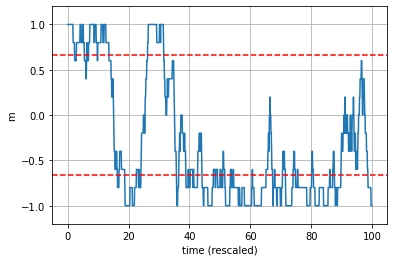

In [ ]:
mEvolution2(10)

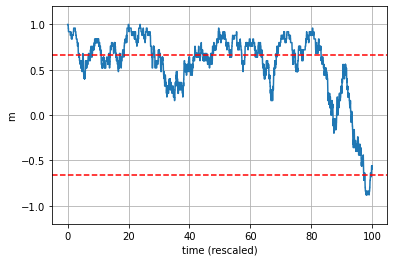

In [ ]:
mEvolution2(50)

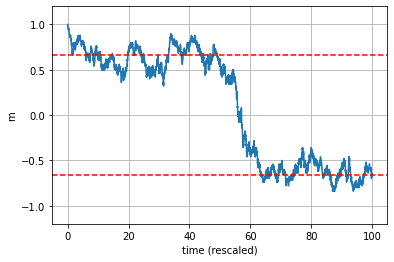

In [ ]:
mEvolution2(100)

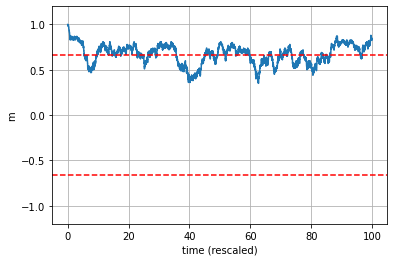

In [ ]:
mEvolution2(200)

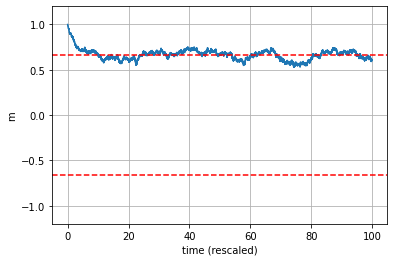

In [ ]:
mEvolution2(1000)

In [ ]:
config = dict(beta=1.2, h=0., N=100)
df = run(100,config)

(-1.0, 1.0)

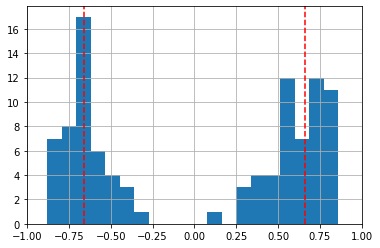

In [ ]:
df[0].hist(bins=20)
plt.axvline(x=-0.65857, linestyle="--", color="r")
plt.axvline(x=0.65857, linestyle="--", color="r")
plt.xlim(-1,1)

### b) with parameters from 1.4.b)

In [ ]:
def mEvolution2(N):
  config = dict(beta=1.2, h=-0.1, N=N)
  model = GlauberModel(**config).multipleUpdates(100*config["N"])
  tspace = np.arange(len(model.history))/config["N"]

  plt.plot(tspace, model.history)
  plt.grid(True)
  plt.xlabel("time (rescaled)")
  plt.ylabel("m")
  plt.axhline(y=-0.787629, linestyle="--", color="r")
  plt.ylim(-1.2,1.2)

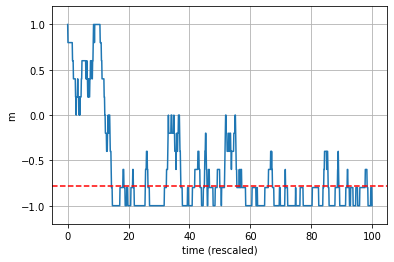

In [ ]:
mEvolution2(10)

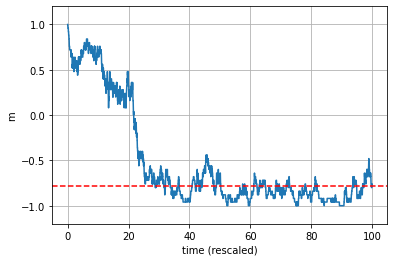

In [ ]:
mEvolution2(50)

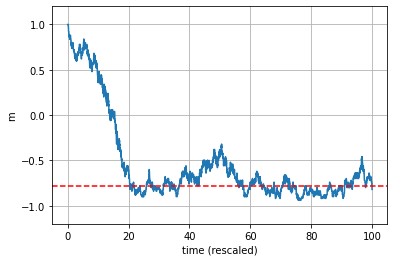

In [ ]:
mEvolution2(100)

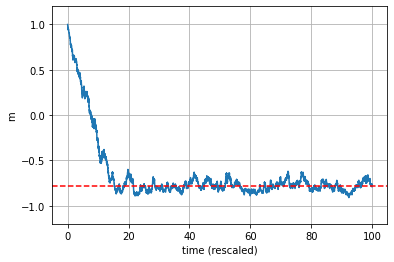

In [ ]:
mEvolution2(200)

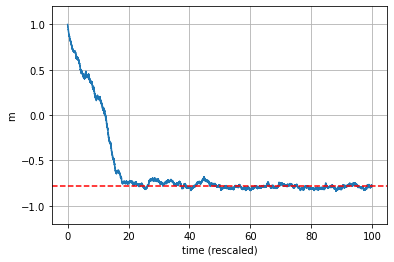

In [ ]:
mEvolution2(1000)

In [ ]:
config = dict(beta=1.2, h=-0.1, N=100)
df = run(100,config)

(-1.0, 1.0)

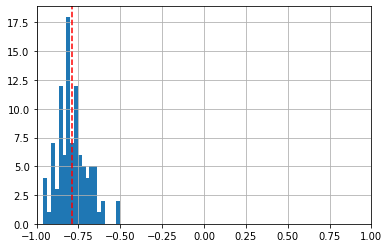

In [ ]:
df[0].hist(bins=20)
plt.axvline(x=-0.787629, linestyle="--", color="r")
plt.xlim(-1,1)

### question e)

In [ ]:
def theoreticalPlots(beta, h):
  T_SPACE = np.linspace(0, 50, 1000)
  cmap = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0., vmax=1.), cmap=mpl.cm.twilight_shifted)
  cmap.set_array([])
  for x0 in np.linspace(-1,1.,50):
    m = sp.integrate.odeint(lambda x,t: -x+np.tanh(beta*(x+h)), x0, T_SPACE)
    plt.plot(T_SPACE, m, c=cmap.to_rgba(abs(x0)))
  plt.grid(True)
  plt.xlabel("time (t)")
  plt.ylabel("m")

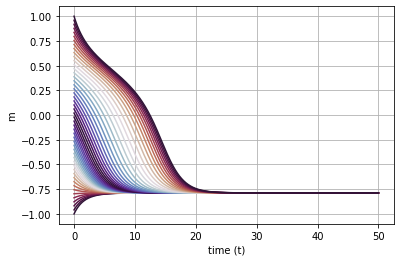

In [ ]:
theoreticalPlots(1.2, -0.1)

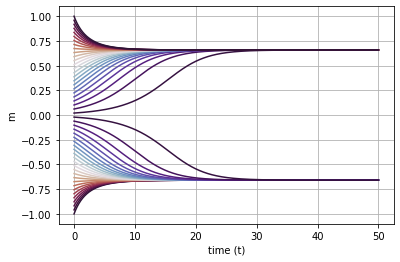

In [ ]:
theoreticalPlots(1.2, 0.)

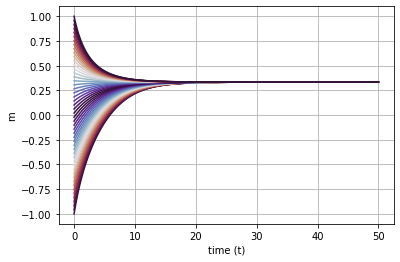

In [ ]:
theoreticalPlots(0.8, 0.1)

In this situation, we see clearly another possible solution from a spurious local maxima depending on the initial solution:

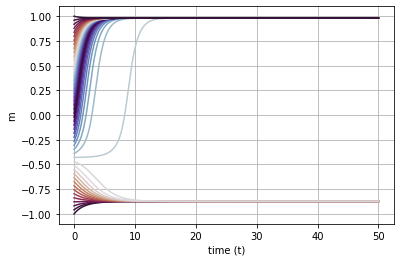

In [ ]:
theoreticalPlots(2., 0.2)

Now let's compare this with the experimental runs for N large enough

In [ ]:
def mEvolution2(N):

  for frac in np.linspace(0.,1.,10):

    u = int(N*abs(frac))
    v = N - u

    spins = np.array([1]*int(u) + [-1]*int(v))
    config = dict(beta=2.0, h=0.2, N=N, spins=spins)
    model = GlauberModel(**config, ).multipleUpdates(50*config["N"])
    tspace = np.arange(len(model.history))/config["N"]

    plt.plot(tspace, model.history)

  plt.grid(True)
  plt.xlabel("time (rescaled)")
  plt.ylabel("m")
  plt.ylim(-1.2,1.2)

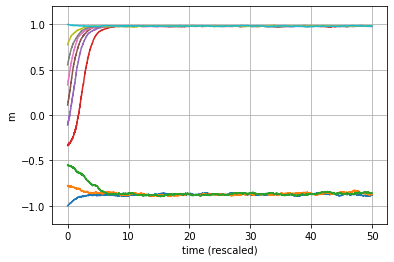

In [ ]:
mEvolution2(5000)

As it can be seen, it matches quite well the curve